In [1]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, BatchNormalization
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import LearningRateScheduler
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

In [2]:
bs = 32  # Batch size
iz = 222  # Image size

In [3]:
train_data_dir = r'D:\Git Projects\Peppermint-Identification-and-Classification-Model\Classification\Data\train'
validation_data_dir = r'D:\Git Projects\Peppermint-Identification-and-Classification-Model\Classification\Data\validation'
test_data_dir = r'D:\Git Projects\Peppermint-Identification-and-Classification-Model\Classification\Data\test'

In [5]:
# Create data generators for the training, validation, and test datasets
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)
validation_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

In [6]:
# Create data generators for training, validation, and test sets
train_generator = train_datagen.flow_from_directory(
    train_data_dir,
    target_size=(iz, iz),
    batch_size=bs,
    class_mode='categorical',
    shuffle=True,
    seed=16
)

validation_generator = validation_datagen.flow_from_directory(
    validation_data_dir,
    target_size=(iz, iz),
    batch_size=bs,
    class_mode='categorical',
    shuffle=True,
    seed=16
)

test_generator = test_datagen.flow_from_directory(
    test_data_dir,
    target_size=(iz, iz),
    batch_size=bs,
    class_mode='categorical',
    shuffle=False
)

Found 3772 images belonging to 4 classes.
Found 806 images belonging to 4 classes.
Found 806 images belonging to 4 classes.


In [7]:
# Determine the number of classes from the generators
num_classes = len(train_generator.class_indices)

In [10]:
# Create a custom Class Identification model with batch normalization and an additional convolutional layer
class_model = keras.Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(iz, iz, 3), name='class_conv1'),
    BatchNormalization(),  # Batch Normalization Layer
    MaxPooling2D((2, 2), name='class_pool1'),
    Conv2D(64, (3, 3), activation='relu', name='class_conv2'),
    BatchNormalization(),  # Batch Normalization Layer
    MaxPooling2D((2, 2), name='class_pool2'),
    Conv2D(128, (3, 3), activation='relu', name='class_conv3'),
    BatchNormalization(),  # Batch Normalization Layer
    MaxPooling2D((2, 2), name='class_pool3'),  # Additional MaxPooling Layer
    Flatten(name='class_flatten'),
    Dense(128, activation='relu', name='class_dense1'),
    Dense(num_classes, activation='softmax', name='class_output')
])

# Learning Rate Scheduling
# def learning_rate_schedule(epoch):
#     initial_learning_rate = 0.001  # Adjust the initial learning rate as needed
#     decay = 0.9  # Adjust the decay factor as needed
#     lr = initial_learning_rate * (decay ** epoch)
#     return lr

# lr_scheduler = LearningRateScheduler(learning_rate_schedule)

# Compile the Class Identification model
class_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train the Class Identification model
class_epochs = 20  # Increase the number of epochs
class_model.fit(train_generator, validation_data=validation_generator, epochs=class_epochs)

Epoch 1/20
118/118 [==============================] - 58s 486ms/step - loss: 4.1619 - accuracy: 0.7187 - val_loss: 22.1648 - val_accuracy: 0.3710
Epoch 2/20
118/118 [==============================] - 58s 492ms/step - loss: 1.0218 - accuracy: 0.7993 - val_loss: 14.4700 - val_accuracy: 0.4442
Epoch 3/20
118/118 [==============================] - 58s 489ms/step - loss: 0.8247 - accuracy: 0.8091 - val_loss: 22.2090 - val_accuracy: 0.4318
Epoch 4/20
118/118 [==============================] - 51s 433ms/step - loss: 0.6118 - accuracy: 0.8415 - val_loss: 16.8455 - val_accuracy: 0.4057
Epoch 5/20
118/118 [==============================] - 56s 474ms/step - loss: 0.6669 - accuracy: 0.8195 - val_loss: 5.0793 - val_accuracy: 0.4814
Epoch 6/20
118/118 [==============================] - 56s 476ms/step - loss: 0.6797 - accuracy: 0.8287 - val_loss: 90.2702 - val_accuracy: 0.0124
Epoch 7/20
118/118 [==============================] - 58s 488ms/step - loss: 0.3798 - accuracy: 0.8621 - val_loss: 1.5803 - v

26/26 [==============================] - 5s 169ms/step - loss: 1.1349 - accuracy: 0.7444
Class Identification Model - Test Accuracy: 74.44%
26/26 [==============================] - 5s 171ms/step


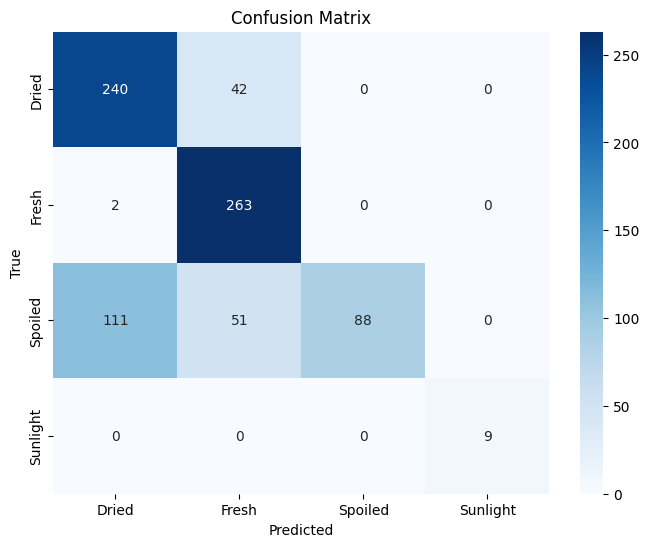

In [11]:
# Evaluate the Class Identification model on the test dataset
test_loss, test_accuracy = class_model.evaluate(test_generator)
print("Class Identification Model - Test Accuracy: {:.2f}%".format(test_accuracy * 100))

# Generate predictions on the test dataset
test_predictions = class_model.predict(test_generator)
test_pred_classes = np.argmax(test_predictions, axis=1)

# Create a list of target names for Class Identification model
class_labels = ['Dried', 'Fresh', 'Spoiled', 'Sunlight']

# Initialize an empty list for true classes
test_true_classes = test_generator.classes

# Calculate the confusion matrix
confusion_mtx = confusion_matrix(test_true_classes, test_pred_classes)

# Create a heatmap for the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_mtx, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

In [12]:
# Generate a classification report for Class Identification model
class_report = classification_report(test_true_classes, test_pred_classes, target_names=class_labels)
print("Class Identification Model - Classification Report:\n", class_report)

Class Identification Model - Classification Report:
               precision    recall  f1-score   support

       Dried       0.68      0.85      0.76       282
       Fresh       0.74      0.99      0.85       265
     Spoiled       1.00      0.35      0.52       250
    Sunlight       1.00      1.00      1.00         9

    accuracy                           0.74       806
   macro avg       0.85      0.80      0.78       806
weighted avg       0.80      0.74      0.72       806

